## Bayesian Optimisation Verification

In [1]:
# import relevant packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import mean_squared_error
# stop showing warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
# Setup data for training and evaluation
X_ = np.linspace(0,5000, 5000)
# import timestamp from data sheet (time:0~5000s) 
address = 'data/degradation.xlsx'
df_time = X_
# import data sheet at 85 C (time:0~5000s) 
df = pd.read_excel(address,sheet_name = 'normal data',usecols = [3],names = None,nrows = 5000)
df_85 = df.values.tolist() 
# df = pd.read_excel(address,sheet_name = 'smooth data',usecols = [3],names = None,nrows = 5000)
# df_85s = df.values.tolist()
# Format date into numpy array format
y_normal = np.array(df_85).T 
y_normal = y_normal.reshape((5000))
x_normal = X_
# x_7_5000 = np.array([0,99,999,1999,2999,3999,4999])

In [3]:
def ucb(X , gp, dim, delta):
	"""
	Calculates the GP-UCB acquisition function values
	Inputs: gp: The Gaussian process, also contains all data
		x:The point at which to evaluate the acquisition function 
	Output: acq_value: The value of the aquisition function at point x
	"""
	mean, var = gp.predict(X[:, np.newaxis], return_cov=True)
	mean = np.atleast_2d(mean).T
	var = np.atleast_2d(var).T  
	beta = 2*np.log(np.power(5000,2.1)*np.square(np.pi)/(3*delta))
	return mean - np.sqrt(beta)* np.sqrt(np.diag(var))

In [4]:
# Plot function to show performance of gp prediction
def plot_performance(list_NOISE_LEVEL,performance_parameter):
    plt.figure()
    plt.plot(list_NOISE_LEVEL, performance_parameter, c='blue', lw=2, zorder=3)
    plt.scatter(list_NOISE_LEVEL, performance_parameter, c='red', s=10, zorder=4)
    plt.xscale('log')
    plt.tick_params(axis='y', colors = 'white')
    plt.tick_params(axis='x', colors = 'white')
    plt.ylabel('Performance parameter',color = 'white')
    plt.xlabel('Number of data points',color = 'white')
    # plt.ylim(0,0.00001)
    # plt.title('Performance of gp',color ='white')
    plt.tight_layout()
    plt.show()

In [24]:
# Plot function to show confidence bounds 
def plot(X_,y_normal,X,y_mean, sigma,gp):
    y_mean = y_mean.reshape(5000)
    sigma = sigma.reshape(5000)
    plt.figure(facecolor='white')
    plt.plot(X_, y_mean, c='blue', lw=1, zorder=4, label='Prediction')
    plt.scatter(X[:, 0], Y, c='r', s=5, zorder=3,label='Trained data')
    plt.fill_between(X_, y_mean - 1.9600 * sigma,y_mean + 1.9600 * sigma,
                        alpha=0.5,color='grey',zorder=1, label='95% confidence interval')
    plt.scatter(X_,y_normal,c='lightblue',s=1,zorder=2, label='Experiment data')
    plt.tick_params(axis='y')
    plt.tick_params(axis='x')
    plt.ylabel('Lifetime')
    plt.xlabel('Time')
    plt.title("Number of data points: %s\nInitial: %s\nOptimum: %s\nLog marginal likelihood: %s" % 
                (X.size,kernel, gp.kernel_,gp.log_marginal_likelihood(gp.kernel_.theta)))
    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
def plot_UCB (X_,y_normal,X,y_mean, sigma,gp):
    y_mean = y_mean.reshape(5000)
    sigma = sigma.reshape(5000)
    y_ucb = ucb(X_,gp,0.1,5)
    y_ucb = y_ucb.reshape(5000)
    plt.figure()
    plt.plot(X_, y_mean, c='blue', lw=1, zorder=4, label='Prediction')
    plt.scatter(X[:, 0], Y, c='r', s=5, zorder=3,label='Trained data')
    plt.fill_between(X_, y_mean - 1.9600 * sigma,y_mean + 1.9600 * sigma,
                        alpha=0.5,color='grey',zorder=2, label='95% confidence interval')
    plt.scatter(X_,y_normal,c='lightblue',s=1,zorder=1, label='Experiment data')
    plt.scatter(X_,y_ucb,c='lightgreen',s=1,zorder=5, label='UCB')
    plt.scatter(np.argmin(y_ucb),y_ucb.min(),c='green',s=10,zorder=6,label = 'UCB minimum point')
    plt.tick_params(axis='y')
    plt.tick_params(axis='x')
    plt.ylabel('Lifetime')
    plt.xlabel('Time')
    plt.title("Number of data points: %s\nLog marginal likelihood: %s" % 
                (X.size,gp.log_marginal_likelihood(gp.kernel_.theta)))
    plt.legend()
    plt.tight_layout()
    plt.savefig('BO_plot.jpg',dpi=600,format='jpg')
    plt.show()

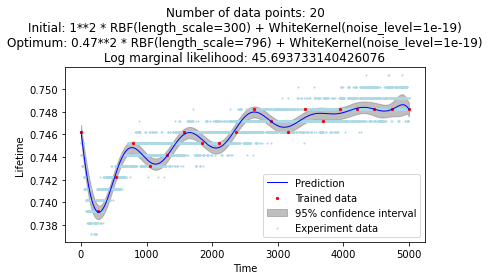

In [25]:
# Testing for UCB auto
NUM_OF_DATA_POINTS = 20
NUM_OF_EXTRA_DATA = 20
NOISE_LEVEL = 10e-20
length_scale_bounds_MAX = 10e4
length_scale_bounds_MIN = 10e-10

# Have data points evenly spread
X = np.arange(0,4998,5000/(NUM_OF_DATA_POINTS-1)).astype(int)
X = np.append(4999,X)
# Randomly chosed data points
# X = np.random.randint(5000, size=NUM_OF_DATA_POINTS)
X = X.reshape(X.size,1)
Y = y_normal[X]
# Kernel setting and prediction
kernel = 1.0 * RBF(length_scale=300) + WhiteKernel(noise_level=NOISE_LEVEL, noise_level_bounds=(1e-20, 10e-4))
gp = GaussianProcessRegressor(kernel=kernel,alpha=10e-8).fit(X, Y)
y_mean, sigma = gp.predict(X_[:, np.newaxis],  return_std=True)
plot(X_,y_normal,X,y_mean, sigma,gp)

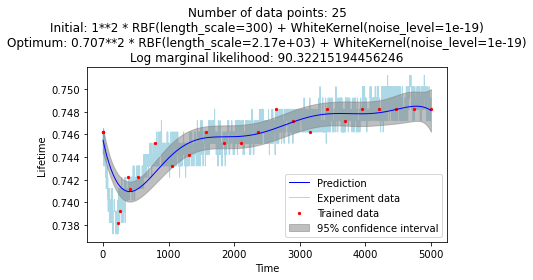

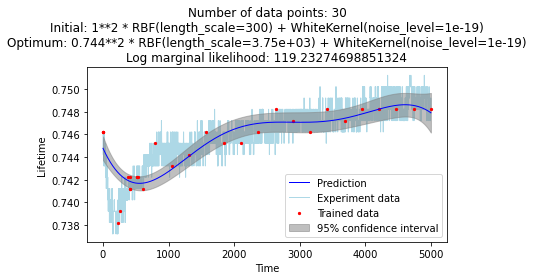

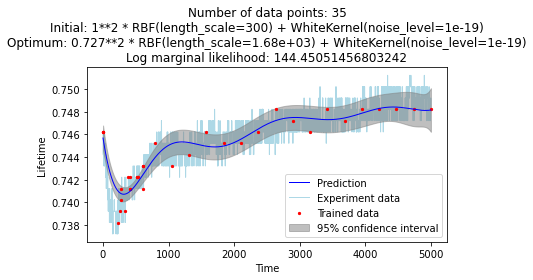

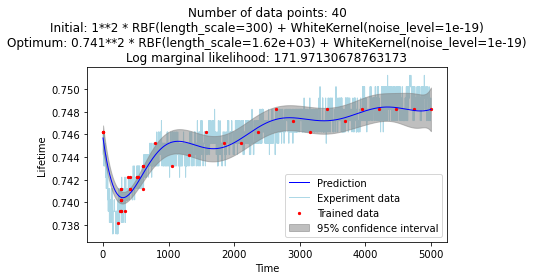

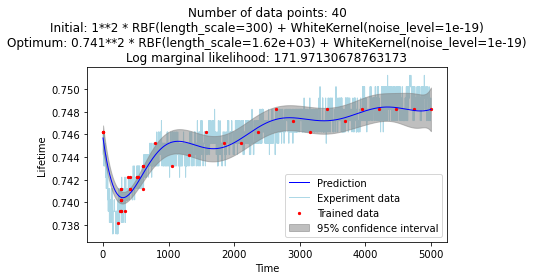

In [26]:
for i in range(NUM_OF_EXTRA_DATA):
    # Add extra point by UCB
    y_ucb = ucb(X_,gp,0.1,5)
    y_ucb = y_ucb.reshape(5000)
    X = np.append(X,np.argmin(y_ucb))
    
    # Add extra point by the distance between prediction adn experiment data
    # y_mean = y_mean.reshape(5000)
    # y_distance = np.absolute(y_mean-y_normal)
    # y_distance = y_distance.reshape(5000)
    # X = np.append(X,np.argmax(y_distance))

    X.sort()
    X=X.reshape(X.size,1)
    Y = y_normal[X]

    # Kernel setting and prediction
    kernel = 1.0 * RBF(length_scale=300) + WhiteKernel(noise_level=NOISE_LEVEL, noise_level_bounds=(1e-20, 10e-4))
    gp = GaussianProcessRegressor(kernel=kernel,alpha=10e-7).fit(X, Y)
    y_mean, sigma = gp.predict(X_[:, np.newaxis],  return_std=True)
    y_mean = y_mean.reshape(5000)
    sigma = sigma.reshape(5000)

    if (i+1)%5 == 0:
        plt.figure(facecolor='white')
        plt.plot(X_, y_mean, c='blue', lw=1, zorder=4, label='Prediction')
        plt.scatter(X[:, 0], Y, c='r', s=5, zorder=3,label='Trained data')
        plt.fill_between(X_, y_mean - 1.9600 * sigma,y_mean + 1.9600 * sigma,
                            alpha=0.5,color='grey',zorder=2, label='95% confidence interval')
        plt.plot(X_,y_normal,c='lightblue',lw=1,zorder=1, label='Experiment data')
        # plt.scatter(np.argmax(y_distance),y_mean[np.argmax(y_distance)],c='green',
        #             s=10,zorder=6,label = 'Next point')
        plt.tick_params(axis='y')
        plt.tick_params(axis='x')
        plt.ylabel('Lifetime')
        plt.xlabel('Time')
        plt.title("Number of data points: %s\nInitial: %s\nOptimum: %s\nLog marginal likelihood: %s" % 
            (X.size,kernel, gp.kernel_,gp.log_marginal_likelihood(gp.kernel_.theta)))
        plt.legend()
        plt.tight_layout()
        plt.show()

plt.figure(facecolor='white')
plt.plot(X_, y_mean, c='blue', lw=1, zorder=4, label='Prediction')
plt.scatter(X[:, 0], Y, c='r', s=5, zorder=3,label='Trained data')
plt.fill_between(X_, y_mean - 1.9600 * sigma,y_mean + 1.9600 * sigma,
                    alpha=0.5,color='grey',zorder=2, label='95% confidence interval')
plt.plot(X_,y_normal,c='lightblue',lw=1,zorder=1, label='Experiment data')
# plt.scatter(np.argmax(y_distance),y_mean[np.argmax(y_distance)],c='green',
#             s=10,zorder=6,label = 'Next point')
plt.tick_params(axis='y')
plt.tick_params(axis='x')
plt.ylabel('Lifetime')
plt.xlabel('Time')
plt.title("Number of data points: %s\nInitial: %s\nOptimum: %s\nLog marginal likelihood: %s" % 
            (X.size,kernel, gp.kernel_,gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# # Experiment to see how mse and lml change with the number 
# # of data points used
# # Set up performance parameters set
# list_mse = np.array([])
# list_lml = np.array([])

# # NUM_OF_DATA_POINTS = 20
# NOISE_LEVEL = 10e-20
# length_scale_bounds_MAX = 10e4
# length_scale_bounds_MIN = 10e-10
# # 
# list_DATA_POINTS = (6,7,8,9,10,12,15,20,24,30,33,37,40,45,50,60,80,100,200)
# # ,250,300,400,500,600,700,800,1000,1200,1400,1700,2000,2500)
# for NUM_OF_DATA_POINTS in list_DATA_POINTS: 
#     # Have data points evenly spread
#     X = np.arange(0,4998,5000/(NUM_OF_DATA_POINTS-1)).astype(int)
#     X = np.append(4999,X)
#     # Randomly chosed data points
#     # X = np.random.randint(5000, size=NUM_OF_DATA_POINTS)
#     X = X.reshape(X.size,1)
#     Y = y_normal[X]
#     print('Number of data points used:', X.size)

#     # Kernel setting
#     kernel = 1.0 * RBF(length_scale=300) + WhiteKernel(noise_level=NOISE_LEVEL,
#     noise_level_bounds=(1e-20, 10e-4))
#     gp = GaussianProcessRegressor(kernel=kernel,alpha=10e-8).fit(X, Y)
#     y_mean, sigma = gp.predict(X_[:, np.newaxis],  return_std=True)
#     y_mean = y_mean.reshape(5000)
#     sigma = sigma.reshape(5000)

#     # print('Noise level =',NOISE_LEVEL)
#     # print ('Average absolute error:',
#     # np.format_float_scientific(np.mean(np.absolute(y_normal-y_mean)),precision=5))
#     # print ('Average percentage error:', np.format_float_positional(np.mean(np.absolute((y_normal-y_mean)/y_normal*100)),precision=4),'%')
#     mse = mean_squared_error(y_normal,y_mean)
#     print ('Mean squared error:', mse)
#     lml = gp.log_marginal_likelihood(gp.kernel_.theta)
#     print ('Log marginal likelihood:', lml)

#     plot(X_,y_normal,X,y_mean, sigma,gp)

#     list_mse = np.append(list_mse,mse)
#     list_lml = np.append(list_lml,lml)

# # plot relevant graphs
# print('\nMean squared error')
# plot_performance(list_DATA_POINTS,list_mse)
# print('Log marginal likelihood')
# plot_performance(list_DATA_POINTS,list_lml)